In [7]:
# Imports
from iexfinance.stocks import Stock
import requests
import urllib.parse
import requests
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import time
import seaborn as sns

In [3]:
# Set-up
period = 'quarter'
time = '24'
symbol = "ADBE"
token = 'Tsk_910a8ace8ad14af698bc4a65be1a4219'

In [4]:
dic = {}

def get_df(portfolio, period, time, token):
    for ticker in portfolio:
        financials_url = f"https://sandbox.iexapis.com/stable/stock/{ticker}/financials?period={period}&last={time}&token={token}"
        financials_json = requests.get(financials_url).json()
        dic[ticker] = pd.DataFrame(financials_json['financials'])

In [5]:
get_df(symbol,period,time,token)

In [6]:
dic['ADBE']

KeyError: 'ADBE'

In [7]:
# URL set-up
income_url = f'https://sandbox.iexapis.com/stable/stock/{symbol}/income?period={period}&last={time}&token=Tsk_910a8ace8ad14af698bc4a65be1a4219'
cash_url = f'https://sandbox.iexapis.com/stable/stock/{symbol}/cash-flow?period={period}&last={time}&token=Tsk_910a8ace8ad14af698bc4a65be1a4219'
balance_url = f'https://sandbox.iexapis.com/stable/stock/{symbol}/balance-sheet?period={period}&last={time}&token=Tsk_910a8ace8ad14af698bc4a65be1a4219'
financials_url = f"https://sandbox.iexapis.com/stable/stock/{symbol}/financials?period={period}&last={time}&token=Tsk_910a8ace8ad14af698bc4a65be1a4219"
fundamentals_url = f"https://sandbox.iexapis.com/stable/time-series/fundamentals/{symbol}/{period}ly?range={time}q&token=Tsk_910a8ace8ad14af698bc4a65be1a4219"
stats_url = f"https://sandbox.iexapis.com/stable/stock/{symbol}/stats?token=Tsk_910a8ace8ad14af698bc4a65be1a4219"

In [8]:
# URL request
income = pd.DataFrame(requests.get(income_url).json()['income'])
cash = pd.DataFrame(requests.get(cash_url).json()['cashflow'])
balance = pd.DataFrame(requests.get(balance_url).json()['balancesheet'])
financials = pd.DataFrame(requests.get(financials_url).json()['financials'])
stats = requests.get(stats_url).json()

In [9]:
tables = [income,cash,balance,financials]

In [10]:
financials['merger'] = financials[['fiscalYear', 'fiscalQuarter']].astype('str').agg('-'.join, axis=1)

In [11]:
def lower_columns(ls):
    for table in ls:
        table.rename(str.lower, axis='columns', inplace=True)

In [41]:
def date_to_index(ls):
    for table in ls:
        table.set_index(pd.to_datetime(table['fiscaldate'].apply(lambda x: x[:7])), inplace=True)

In [42]:
lower_columns(tables)
date_to_index(tables)

In [45]:
cash.index

DatetimeIndex(['2020-11-01', '2020-08-01', '2020-05-01', '2020-02-01',
               '2019-11-01', '2019-08-01', '2019-05-01', '2019-02-01',
               '2018-11-01', '2018-08-01', '2018-05-01', '2018-03-01',
               '2017-11-01', '2017-08-01', '2017-05-01', '2017-02-01',
               '2016-11-01', '2016-08-01', '2016-05-01', '2016-02-01',
               '2015-11-01', '2015-08-01', '2015-05-01', '2015-02-01'],
              dtype='datetime64[ns]', name='fiscaldate', freq=None)

In [15]:
# Collection table
collection = pd.DataFrame()
collection = financials[['revenue','netincome','operatingincome','cashflow','ebitda','totalassets','totalcash','totaldebt','shareholderequity','merger']]
cash['fcf'] = cash.loc[:,'cashflow'] - cash.loc[:,'capitalexpenditures']
collection = collection.merge(cash['fcf'], left_index=True,right_index=True)

In [16]:
collection_q = collection.copy()
collection_q['time'] = 'q'
collection_y = collection.groupby(pd.Grouper(freq='y')).agg({'revenue':'sum', 'netincome':'sum', 'operatingincome':'sum'})
collection_y['time'] = 'y'

In [17]:
def add_profitability(df):
    df['operating_margin'] = df['operatingincome'] / df['revenue']
    df['net_margin'] = df['netincome'] / df['revenue']
    df['asset_turnover'] = df['revenue'] / df['totalassets']
    df['roa'] = df['netincome']*4/ df['totalassets']
    df['equity_multipl'] = df['totalassets'] / df['shareholderequity']
    df['roe'] = df['netincome'] / df['shareholderequity']
    df['fcf_margin'] = df['fcf'] / df['revenue']

In [18]:
def add_financial_strength(df):
    df['cash_debt'] = df['totalcash'] / df['totaldebt']
    df['equity_asset'] = df['shareholderequity'] / df['totalassets']
    df['debt_equity'] = df['totaldebt'] / df['shareholderequity']
    df['debt_ebitda'] = df['totaldebt'] / (df['ebitda']*4)

In [19]:
add_profitability(collection_q)
add_financial_strength(collection_q)

In [53]:
collection_q.columns

Index(['revenue', 'netincome', 'operatingincome', 'cashflow', 'ebitda',
       'totalassets', 'totalcash', 'totaldebt', 'shareholderequity', 'merger',
       'fcf', 'time', 'operating_margin', 'net_margin', 'asset_turnover',
       'roa', 'equity_multipl', 'roe', 'fcf_margin', 'cash_debt',
       'equity_asset', 'debt_equity', 'debt_ebitda'],
      dtype='object')

Text(0, 0.5, '$ billions')

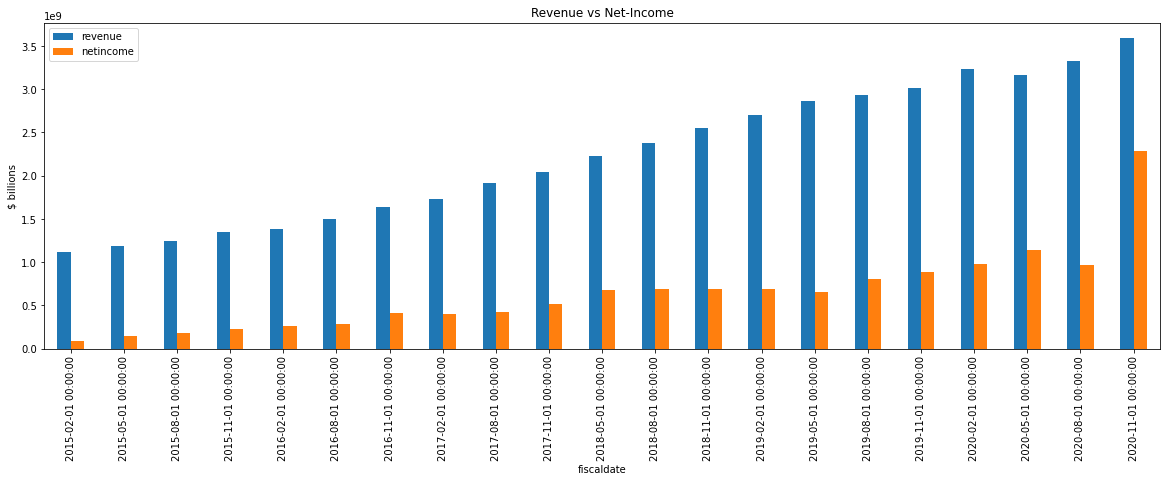

In [51]:
collection_q[['revenue','netincome']].sort_index().plot(kind='bar',figsize=(20,6))
plt.title("Revenue vs Net-Income")
plt.ylabel("$ billions")

Text(0, 0.5, '%')

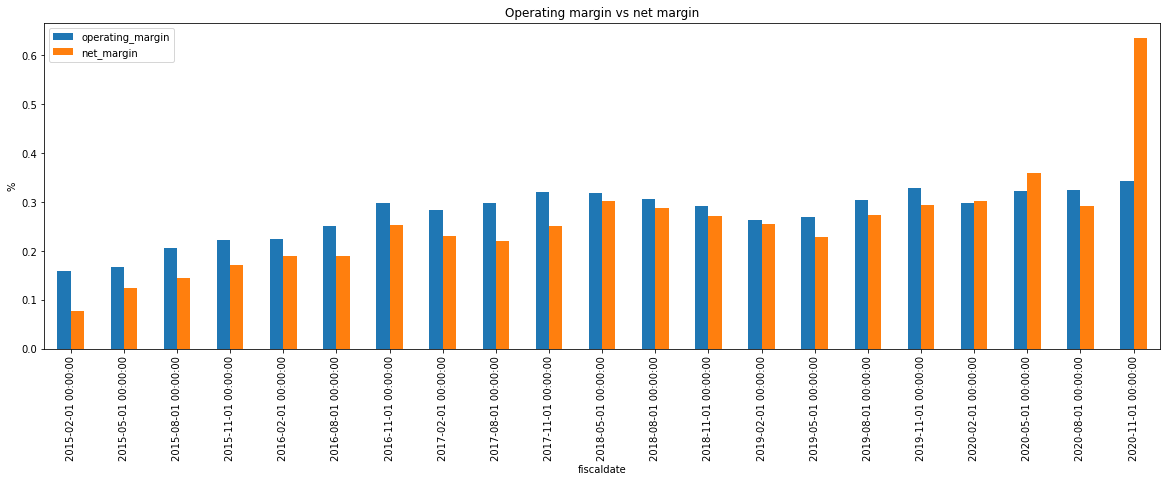

In [60]:
collection_q[['operating_margin','net_margin']].sort_index().plot(kind='bar',figsize=(20,6))
plt.title("Operating margin vs net margin")
plt.ylabel("%")

Text(0, 0.5, '%')

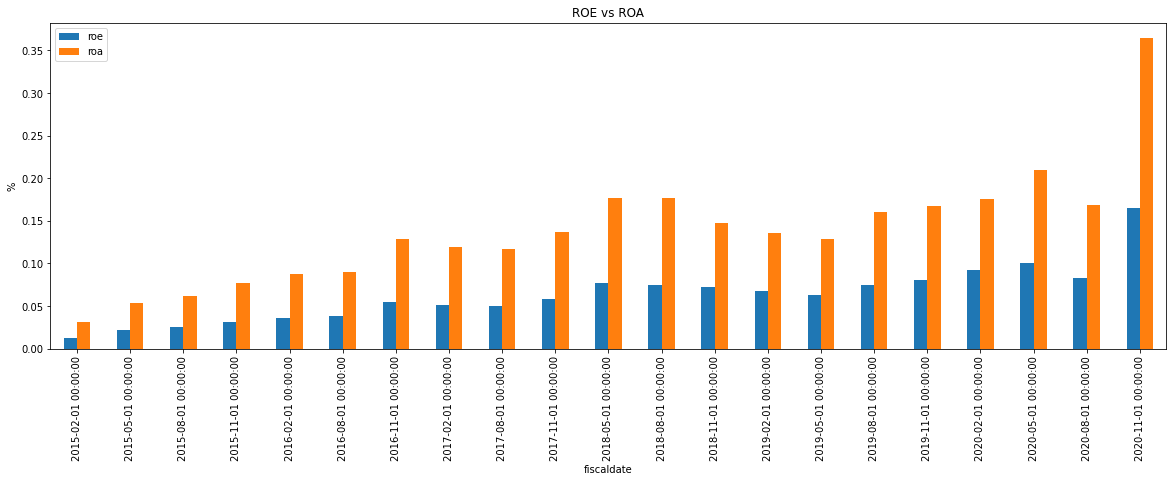

In [62]:
collection_q[['roe','roa']].sort_index().plot(kind='bar',figsize=(20,6))
plt.title("ROE vs ROA")
plt.ylabel("%")

In [10]:
requests.get(f"https://sandbox.iexapis.com/stable/stock/{symbol}/company?token={token}").json()

{'symbol': 'ADBE',
 'companyName': 'Adobe Inc',
 'exchange': 'SDLSGS NA)RGAO  QAKLLBNET(AMEE/CT',
 'industry': 'ribeSsoh wesPatulfr',
 'website': 'ac:dme/woob/w/h.pswtt.',
 'description': '0',
 'CEO': 'uaaSann hNaretyn',
 'securityName': 'd enoAIbc',
 'issueType': 'sc',
 'sector': 'tmroaoIfnni',
 'primarySicCode': 7545,
 'employees': None,
 'tags': ['oeTgSeirsnoh yccvle',
  'adfea ecwtorPSgka',
  'mifaonIrnto',
  'fbrlwtesrisPeouhS a'],
 'address': '4v 3AP re5ka',
 'address2': None,
 'state': 'aCniiafrlo',
 'city': 'enoSsJa ',
 'zip': '1-45001729',
 'country': 'SU',
 'phone': '14731838891'}